# General Text Word Clouds 

### wcloudimage.py  and wcloudimagenocovid.py

In order to create the word clouds, we need the following packages:

In [1]:
import pandas as pd
import numpy as np
import json
#import sys
import string
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import emoji
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt 
from PIL import Image
import nltk
from nltk.corpus import stopwords
import itertools
import altair as alt

Then we have defined the following functions to clean the tweets' text:

In [2]:
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_urls(text):
    result = re.sub(r"http\S+", "", text)
    return(result)

def remove_twitter_urls(text):
    clean = re.sub(r"pic.twitter\S+", "",text)
    return(clean)

def give_emoji_free_text(text):
    return emoji.get_emoji_regexp().sub(r'', text)

def noamp(text):
    clean = re.sub("&amp", " ",text)
    return (clean)

To read the JSON file that has all the tweets, it is necessary to do:

In [3]:
data = []
with open('dataset/general_result_translated_full.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

We're interested in the "full_text" field, that it has been cleaned with specific functions:

In [4]:
index=0
comment_words = ''
stop_words = stopwords.words('english')
for element in data:
    data[index]['full_text'] = data[index]['full_text'].lower()                   # Put everything in lowercase
    #data[index]['full_text'] = contractions.fix(data[index]['full_text'])
    data[index]['full_text'] = re.sub("\'\w+", '', data[index]['full_text'])      # Remove everything after '
    data[index]['full_text'] = remove_urls(data[index]['full_text'])
    data[index]['full_text'] = remove_twitter_urls(data[index]['full_text'])
    data[index]['full_text'] = remove_emoticons(data[index]['full_text'])
    data[index]['full_text'] = remove_emoji(data[index]['full_text'])
    data[index]['full_text'] = give_emoji_free_text(data[index]['full_text'])
    data[index]['full_text'] = noamp(data[index]['full_text'])                    # No amp with space
    data[index]['full_text'] = re.sub("#\S+", " ",  data[index]['full_text'])     # Remove hashtags
    data[index]['full_text'] = re.sub("@\S+", " ",  data[index]['full_text'])     # No mentions
    data[index]['full_text'] = data[index]['full_text'].translate(str.maketrans('', '', string.punctuation)) # No puntuaction
    data[index]['full_text'] = data[index]['full_text'].encode('ascii', 'ignore').decode() # No unicode
    data[index]['full_text'] = re.sub("^rt ", " ", data[index]['full_text'])      # No RT
    data[index]['full_text'] = re.sub('\s{2,}', " ", data[index]['full_text'])    # Remove big spaces

    
    tokens=data[index]['full_text'].split()

    comment_words += " ".join(tokens)+" "
    index=index+1

Then the word cloud is created:

In [5]:
mask_covid= np.array(Image.open('grafici/face_mask.jpg'))

wordcloud_covid = WordCloud(background_color ='white',
            mask=mask_covid,
            width=mask_covid.shape[1],
            height=mask_covid.shape[0],
            stopwords = stop_words,
            normalize_plurals=False,
            min_word_length = 3,
            max_words=400,
            font_path = 'grafici/GothamMedium.ttf',
            min_font_size = 10).generate(comment_words)

Plot the word cloud (WITH terms regarding Covid):

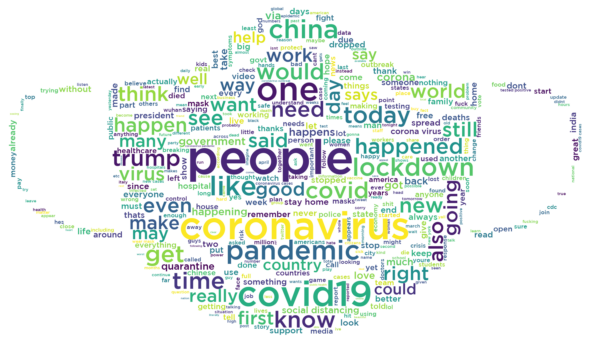

In [6]:
# Plot the Word Cloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_covid,interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show() 

We have created a bar chart showing the 15 most used words within the dataset:

In [7]:
distribuzione = wordcloud_covid.process_text(comment_words)
#print(distribuzione)
fdist_sorted = dict(sorted(distribuzione.items(), key=lambda item: item[1], reverse=True))
#print(fdist_sorted)
out = dict(itertools.islice(fdist_sorted.items(), 15))

df = pd.DataFrame.from_dict(out, orient='index').reset_index()
df = df.rename(columns={'index':'words', 0:'count'})
#print(df)
alt.renderers.enable('altair_viewer',inline=True)


alt.Chart(
    df,
    title = "Most 15 frequent words (Covid related) in the dataset"
).mark_bar().encode(
    x=alt.X('count:Q'),
    y=alt.Y('words:N',sort='-x'),
    color=alt.Color('count:Q',scale=alt.Scale(scheme="greens"))
).transform_window(
    rank='rank(count)',
    sort=[alt.SortField('count', order='descending')]
).transform_filter(
    (alt.datum.rank < 15)
)

alt.Chart(...)

We have also created a word cloud without terms regarding Covid, so we have filtered these words from the "full_text" field:

In [8]:
index_nocovid=0
comment_words_nocovid = ''
stopwords = ["coronawarriors","covid19australia","vaccine","coronacrisis","coronaviruskenya","covidiots","covid19uk","lockdownsa","covidiot","chinesevirus","pandemic","coronaviruslockdown","quarantinelife","sarscov2","coronalockdown","coronaupdate","covid19us","nomeat_nocoronavirus","covid19india","coronavirusupdate","quarantine","lockdown","chinavirus","coronaviruschina","coronavirusuk","wuhanvirus","coronavirusupdates","covid19pandemic","coronavirususa","covid19nigeria","coronaviruschina","coronarvirus","coronaoutbreak","ncov2019","2019ncov","chinacoronavirus","coronavirussa","wuhancoronavirus","coronarovirus","indiafightscorona","covid19", "coronavirus", "corona", "covid_19", "covid","coronavirusoutbreak","covid2019", "virus", "covid__19","covid19aus", "coronavirusindia","covidー19", "coronaviruspandemic"]
for element in data:
    data[index_nocovid]['full_text'] = data[index_nocovid]['full_text'].lower()                # Put everything in lowercase
    #data[index]['full_text'] = contractions.fix(data[index]['full_text'])
    data[index_nocovid]['full_text'] = re.sub("\'\w+", '', data[index_nocovid]['full_text'])   # Remove everything after '
    data[index_nocovid]['full_text'] = remove_urls(data[index_nocovid]['full_text'])
    data[index_nocovid]['full_text'] = remove_twitter_urls(data[index_nocovid]['full_text'])
    data[index_nocovid]['full_text'] = remove_emoticons(data[index_nocovid]['full_text'])
    data[index_nocovid]['full_text'] = remove_emoji(data[index_nocovid]['full_text'])
    data[index_nocovid]['full_text'] = give_emoji_free_text(data[index_nocovid]['full_text'])
    data[index_nocovid]['full_text'] = noamp(data[index_nocovid]['full_text'])                 # No amp with space
    data[index_nocovid]['full_text'] = re.sub("#\S+", " ",  data[index_nocovid]['full_text'])  # Remove hashtags
    data[index_nocovid]['full_text'] = re.sub("@\S+", " ",  data[index_nocovid]['full_text'])  # No mentions
    data[index_nocovid]['full_text'] = data[index_nocovid]['full_text'].translate(str.maketrans('', '', string.punctuation)) # No puntuaction
    data[index_nocovid]['full_text'] = data[index_nocovid]['full_text'].encode('ascii', 'ignore').decode() # No unicode
    data[index_nocovid]['full_text'] = re.sub("^rt ", " ", data[index_nocovid]['full_text'])   # No RT
    data[index_nocovid]['full_text'] = re.sub('\s{2,}', " ", data[index_nocovid]['full_text']) # Remove big spaces

    
    tokens_nocovid=data[index_nocovid]['full_text'].split()

    comment_words_nocovid += " ".join(tokens_nocovid)+" "
    index_nocovid=index_nocovid+1

The word cloud is generated:

In [9]:
mask= np.array(Image.open('grafici/twitter.jpg'))

wordcloud = WordCloud(background_color ='white',
            mask=mask,
            width=mask.shape[1],
            height=mask.shape[0],          
            stopwords = stopwords, 
            normalize_plurals=False,
            min_word_length = 3,
            font_path = 'grafici/GothamMedium.ttf',
            min_font_size = 10).generate(comment_words_nocovid)

Plot the word cloud (WITHOUT terms regarding Covid):

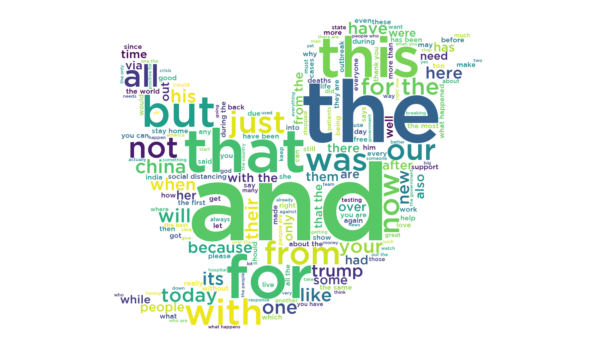

In [10]:
# Plot the Word Cloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud,interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

Then the bar chart showing the 15 top words within the dataset, always without considering terms regarding Covid, is created:

In [11]:
dis = wordcloud.process_text(comment_words_nocovid)
#print(distribuzione)
fdist_sorted_nocovid = dict(sorted(dis.items(), key=lambda item: item[1], reverse=True))
#print(fdist_sorted)
out_nocovid = dict(itertools.islice(fdist_sorted_nocovid.items(), 15))

df_nocovid = pd.DataFrame.from_dict(out_nocovid, orient='index').reset_index()
df_nocovid = df_nocovid.rename(columns={'index':'words', 0:'count'})
alt.renderers.enable('altair_viewer',inline=True)


alt.Chart(
    df_nocovid,
    title = "Most 15 frequent words (NOT Covid related) in the dataset"
).mark_bar().encode(
    x=alt.X('count:Q'),
    y=alt.Y('words:N',sort='-x'),
    color=alt.Color('count:Q',scale=alt.Scale(scheme="blues"))
).transform_window(
    rank='rank(count)',
    sort=[alt.SortField('count', order='descending')]
).transform_filter(
    (alt.datum.rank < 15)
)

alt.Chart(...)